In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prophet
import yfinance as yf
import seaborn as sns

# Load MS dataset



In [139]:
# get Microsoft stock data
df = pd.DataFrame()
ticker = yf.Ticker("MSFT")
df = ticker.history(start="2022-01-01")

df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
df.reset_index(inplace=True)
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
365,2023-06-16,351.320007,351.470001,341.950012,342.329987,46533600
366,2023-06-20,339.309998,342.079987,335.859985,338.049988,26375400
367,2023-06-21,336.369995,337.730011,332.070007,333.559998,25117800
368,2023-06-22,334.119995,340.119995,333.339996,339.709991,23556800
369,2023-06-23,334.359985,337.959991,333.450012,335.019989,23084700


# Preprocessing

In [140]:
df_prophet = df[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2022-01-03,330.092255
1,2022-01-04,324.432159
2,2022-01-05,311.977844
3,2022-01-06,309.512665
4,2022-01-07,309.670441


In [141]:
train_indices = df_prophet.ds < '2023-06-01'
df_train = df_prophet[train_indices].dropna()
df_test = df_prophet[~train_indices].reset_index(drop=True)

print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)

Training set shape: (354, 2)
Test set shape: (16, 2)


# Fit model

In [142]:
model_prophet = prophet.Prophet(seasonality_mode='additive')
model_prophet.fit(df_train)

12:40:37 - cmdstanpy - INFO - Chain [1] start processing


12:40:37 - cmdstanpy - INFO - Chain [1] done processing


# Predcition

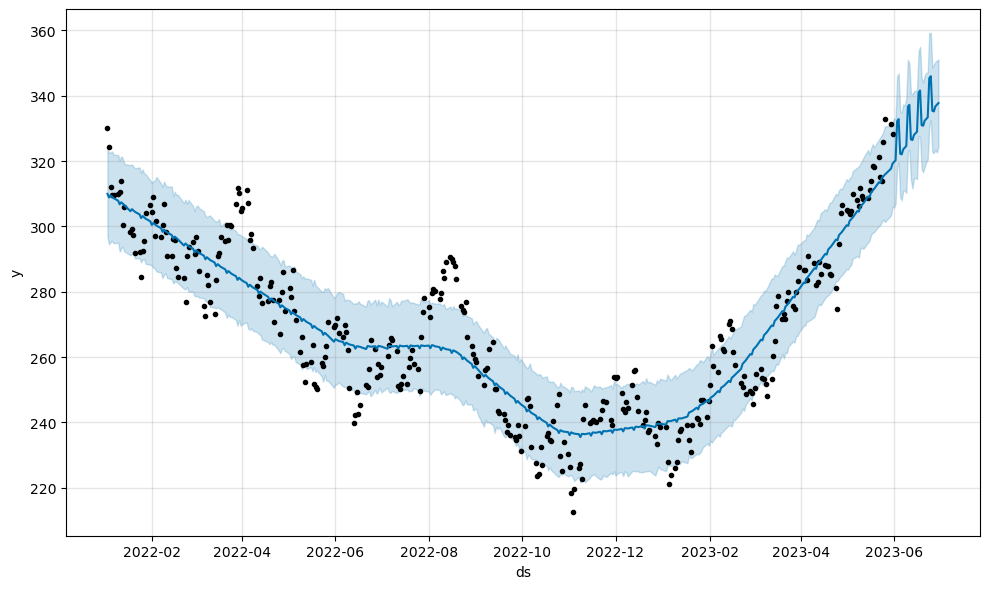

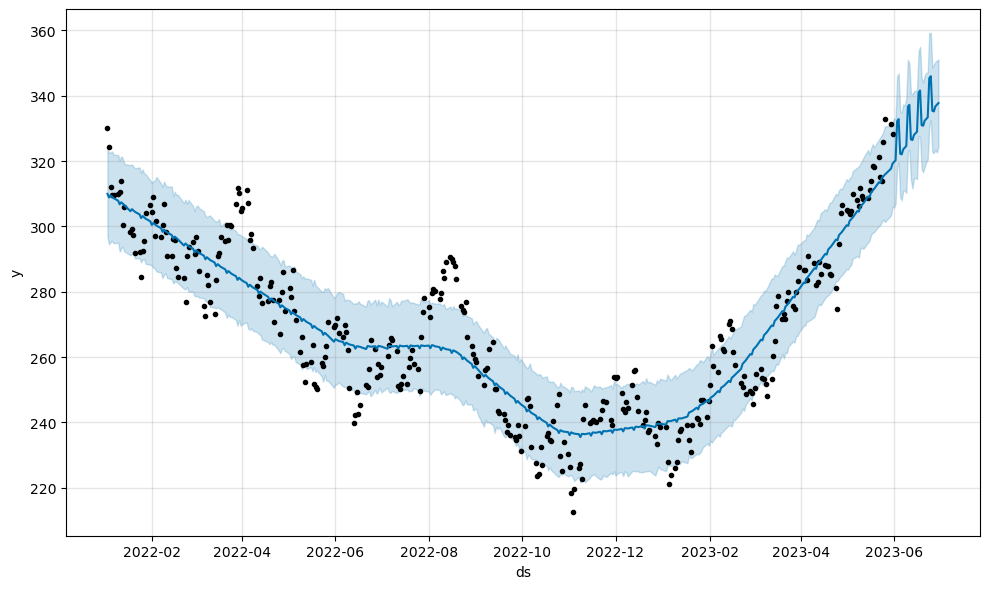

In [143]:
df_future = model_prophet.make_future_dataframe(periods=30)
df_pred = model_prophet.predict(df_future)

model_prophet.plot(df_pred)

# Model validation

In [144]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)

print(df_test)
print(df_pred)

            ds           y
0   2023-06-01  332.579987
1   2023-06-02  335.399994
2   2023-06-05  335.940002
3   2023-06-06  333.679993
4   2023-06-07  323.380005
5   2023-06-08  325.260010
6   2023-06-09  326.790009
7   2023-06-12  331.850006
8   2023-06-13  334.290009
9   2023-06-14  337.339996
10  2023-06-15  348.100006
11  2023-06-16  342.329987
12  2023-06-20  338.049988
13  2023-06-21  333.559998
14  2023-06-22  339.709991
15  2023-06-23  335.019989
            ds  yhat_lower  yhat_upper        yhat
0   2022-01-03  296.882321  323.475197  309.976507
1   2022-01-04  294.527123  322.730591  308.863436
2   2022-01-05  295.142052  322.512722  309.488828
3   2022-01-06  295.598134  322.934703  309.091512
4   2022-01-07  294.844333  322.005433  308.659892
..         ...         ...         ...         ...
379 2023-06-26  322.737855  348.594063  335.383027
380 2023-06-27  322.483357  349.505035  335.195944
381 2023-06-28  323.517338  350.317048  336.747324
382 2023-06-29  322.620177  350

In [145]:
df_test.ds = pd.to_datetime(df_test.ds).dt.strftime('%Y-%m-%d')
df_pred.ds = pd.to_datetime(df_pred.ds).dt.strftime('%Y-%m-%d')
df_merge = df_test.merge(df_pred, on='ds', how='left')
df_merge

,ds,y,yhat_lower,yhat_upper,yhat
0,2023-06-01,332.579987,305.763309,333.060680,319.757991
1,2023-06-02,335.399994,306.999077,333.038748,320.252360
2,2023-06-05,335.940002,308.865940,335.202487,322.244522
3,2023-06-06,333.679993,308.025180,334.843346,322.057440
4,2023-06-07,323.380005,310.899215,337.345537,323.608820
5,2023-06-08,325.260010,311.000476,336.959057,324.137493
6,2023-06-09,326.790009,310.218092,339.160758,324.631861
7,2023-06-12,331.850006,314.307937,340.631854,326.624024
8,2023-06-13,334.290009,311.590708,340.485023,326.436942
9,2023-06-14,337.339996,314.767285,341.386182,327.988321


Text(0.5, 1.0, 'Microsoft Stock Price Prediction')

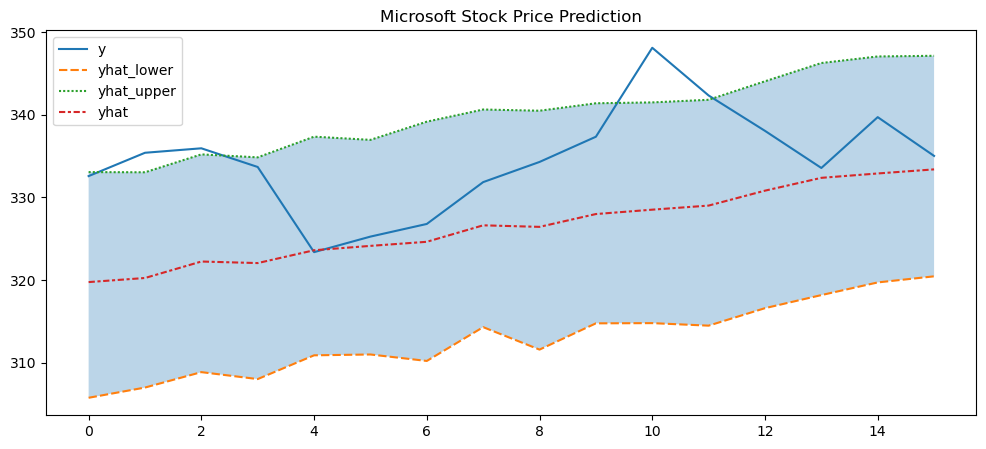

In [146]:
fig9, ax9 = plt.subplots(figsize=(12, 5))
ax9 = sns.lineplot(data=df_merge[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax9.fill_between(df_merge.index, df_merge.yhat_lower, df_merge.yhat_upper, alpha=0.3)
ax9.set_title('Microsoft Stock Price Prediction')
